In [1]:
#r "nuget: Plotly.NET.Interactive"
#r "nuget: Plotly.NET.ImageExport"
#load "./Camara.fsx"

open System
open Camara
open Html

let baseUrl = "https://camaradosdeputadosgql-qboe6n5gda-uc.a.run.app/graphql"
//let baseUrl = "https://localhost:7043/graphql"
let client = Camara.Client(baseUrl)

Installed Packages Plotly.NET.ImageExport, 5.0.1 Plotly.NET.Interactive, 4.2.1

Loading extensions from `C:\Users\victo\.nuget\packages\plotly.net.interactive\4.2.1\interactive-extensions\dotnet\Plotly.NET.Interactive.dll`

In [2]:
// Lista todos os deputados da atual legislatura e suas informações básicas em uma tabela
let view (deputies:Model.Deputy[]) = 
    table [] [
        tr [] [
            th [] [ "Id" ]
            th [] [ "Nome" ]
            th [] [ "Partido" ]
            th [] [ "Estado" ]
            th [] [ "" ]
        ]
        for deputy in deputies do
            tr [] [
                td [] [ deputy.id ]
                td [] [ deputy.name ]
                td [] [ deputy.party ]
                td [] [ deputy.state ]
                td [] [ img [ _src deputy.picture; _width "32px" ] [] ]
            ]
    ]

let viewExpenses (deputies:Model.Deputy) =
    table [] [
        tr [] [
            th [] [ "Fornecedor" ]
            th [] [ "Tipo de despesa" ]
            th [] [ "CPF/CNPJ" ]
            th [] [ "Valor líquido" ]
            th [] [ "Data da Nota" ]
        ]
        for expense in deputies.expenses do
            tr [] [
                td [] [ expense.supplierName ]
                td [] [ expense.expenseType ]
                td [] [ expense.supplierCnpjOrCpf ]
                td [] [ $"R$ {expense.netValue}" ]
                td [] [ expense.documentDate ]
            ]
    ]

In [3]:
let YEAR = 2023
let MONTH = Nullable<int>()
let deputies = client.GetDeputyExpenses(204507, YEAR, MONTH).deputies
display ( view deputies )

Id,Nome,Partido,Estado,
204507,Carla Zambelli,PL,SP,


In [18]:
// Funções para plotar gráficos	

open Plotly.NET
open Plotly.NET.LayoutObjects
open Plotly.NET.ImageExport

let logValueAxis = LinearAxis.init(
    Title=Title.init(Text = "Valor (R$)")
    )

let expenseTypeOverTime (deputy:Model.Deputy) =
    if Array.isEmpty deputy.expenses then
        Chart.StackedArea([||], [||])
    else
    deputy.expenses
    |> Seq.groupBy (fun e -> e.expenseType)
    |> Seq.map(fun (expenseType, expenses) -> 
        let dates, values =
            expenses
            |> Seq.filter(fun it -> it.documentDate.HasValue)
            |> Seq.sortBy(fun it -> it.documentDate.Value)
            |> Seq.map(fun it -> it.documentDate.Value.Date, it.netValue)
            |> Seq.toArray
            |> Array.unzip
        Chart.StackedArea(dates, values, Name=expenseType)
        |> Chart.withLineStyle(Shape = StyleParam.Shape.Hvh)
    )
    |> Chart.combine
    |> Chart.withYAxis logValueAxis
    |> Chart.withLegendStyle(Orientation = StyleParam.Orientation.Horizontal)
    |> Chart.withLayoutStyle(Width = 1000, Height = 600)
    |> Chart.withTitle($"{deputy.name} - {deputy.party} - {deputy.state} - {MONTH}/{YEAR}")

let expenseTypePieChart (deputy:Model.Deputy) =
    deputy.expenses
    |> Seq.groupBy (fun e -> e.expenseType)
    |> Seq.map(fun (expenseType, expenses) -> 
        let totalValue = expenses |> Seq.sumBy(fun it -> it.netValue)
        expenseType, totalValue
    )
    |> Seq.toArray
    |> Array.unzip
    |> fun (labels, values) -> 
        let total = values |> Array.sum
        Chart.Pie(values=values, Labels=labels)
        |> Chart.withTitle($"{deputy.name} - {deputy.party} - {deputy.state} - R$ {total} - {MONTH}/{YEAR}")
        |> Chart.withLegendStyle(Orientation = StyleParam.Orientation.Horizontal)

let supplierTotalsBarChart (threshold) (deputy:Model.Deputy) =
    deputy.expenses
    |> Seq.groupBy (fun e -> e.supplierName)
    |> Seq.map(fun (supplier, expenses) -> 
        let totalValue = expenses |> Seq.sumBy(fun it -> it.netValue)
        supplier, totalValue
    )
    |> Seq.sortByDescending(fun (supplier, totalValue) -> totalValue)
    |> Seq.filter (fun (supplier, totalValue) -> totalValue > threshold )
    |> Seq.toArray
    |> Array.unzip
    |> fun (labels, values) -> 
        let total = values |> Array.sum
        Chart.Column(values = values, Keys=labels)
        |> Chart.withTitle($"{deputy.name} - {deputy.party} - {deputy.state} - Gastos acima de R$ {threshold} - {MONTH}/{YEAR}")
        |> Chart.withLegendStyle(Orientation = StyleParam.Orientation.Horizontal)

let displaySVG width height chart =
    let graph =
        chart
        |> Chart.toSVGString( Width = width, Height = height)
    DisplayExtensions.DisplayAs(graph,"image/svg+xml")

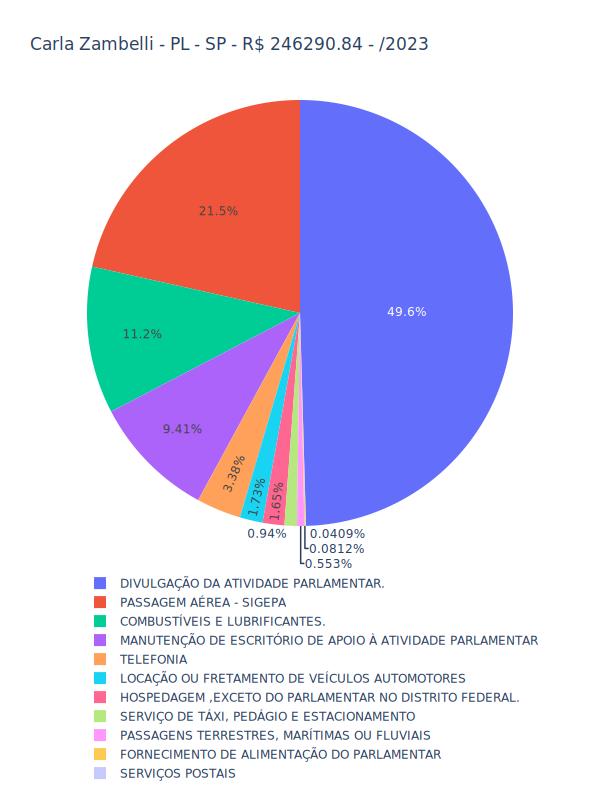

In [6]:
deputies.[0]
|> expenseTypePieChart
|> displaySVG 600 800

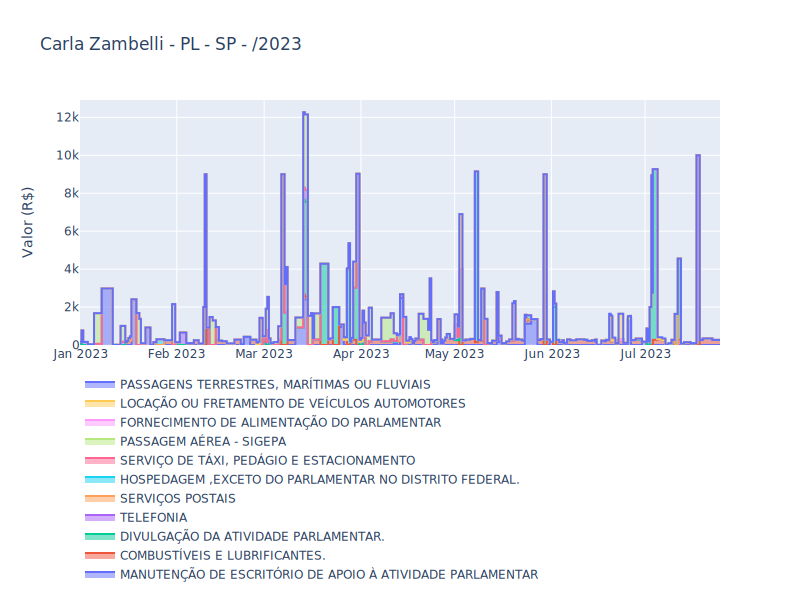

In [20]:
deputies.[0]
|> expenseTypeOverTime
|> displaySVG 800 600

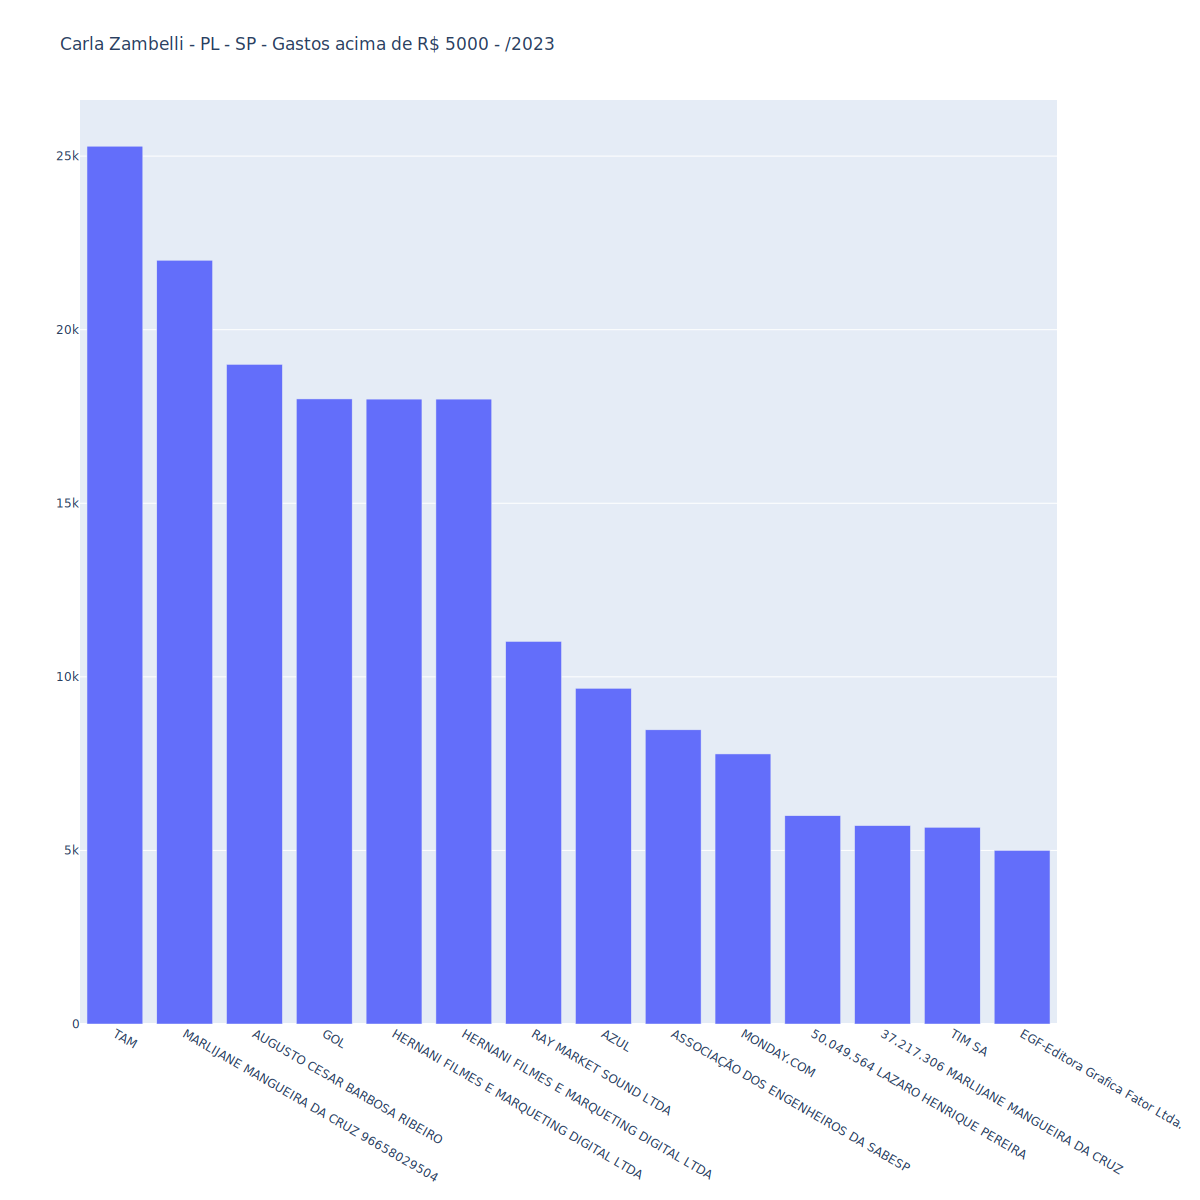

In [19]:
deputies.[0]
|> supplierTotalsBarChart 5000M
|> displaySVG 1200 1200

In [7]:
deputies.[0]
|> viewExpenses

Fornecedor,CPF/CNPJ,Valor líquido,Data da Nota
ASSOCIAÇÃO DOS ENGENHEIROS DA SABESP,56765472000190,R$ 2406.42,2023-01-18 00:00:00Z
IZUMI INFORMATICA LTDA,08604726000145,R$ 2976.0,2023-01-10 00:00:00Z
MONDAY.COM,00000000000010,R$ 910.0,2023-01-23 00:00:00Z
Telefônica Brasil S.A. VIVO,02558157000162,R$ 165.98,2023-01-01 00:00:00Z
AUTO POSTO MUNICIPAL DE ANDRADAS LTDA,44059126000107,R$ 150.0,2023-01-16 00:00:00Z
DECIO COM E SERV ROD LTDA,19046218001772,R$ 193.8,2023-01-16 00:00:00Z
MAKRO ATACADISTA S A,47427653007632,R$ 162.59,2023-01-17 00:00:00Z
MARINER AUTO POSTO RIBEIRAO LTDA,08225043000187,R$ 134.74,2023-01-16 00:00:00Z
PLANETA REVENDEDORA DE COMBUSTIVEIS,05236122000103,R$ 243.05,2023-01-17 00:00:00Z
POSTO DA TORRE EIRELI EPP,04473193000159,R$ 252.2,2023-01-30 00:00:00Z


In [8]:
let legislature = client.GetLegislature(DateTime.Now).legislatures.[0]
display (view (legislature.deputies))

Id,Nome,Partido,Estado,
220593,Abilio Brunini,PL,MT,
204379,Acácio Favacho,MDB,AP,
220714,Adail Filho,REPUBLICANOS,AM,
221328,Adilson Barroso,PL,SP,
204560,Adolfo Viana,PSDB,BA,
204528,Adriana Ventura,NOVO,SP,
121948,Adriano do Baldy,PP,GO,
74646,Aécio Neves,PSDB,MG,
160508,Afonso Florence,PT,BA,
136811,Afonso Hamm,PP,RS,
